In [ ]:
!nvidia-smi

Mon Jun 27 15:36:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models
from torchvision.transforms import transforms as tt
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [ ]:
!wget https://www.dropbox.com/s/7antd9p73d8egn3/train_dataset_train_ufa.zip
!wget https://www.dropbox.com/s/bq1xli6jpf8hujn/test_dataset_test_ufa.zip
!unzip train_dataset_train_ufa.zip
!unzip test_dataset_test_ufa.zip -d /content/test/

In [ ]:
noise_ids = '''
411
100
99
259
406
29
253
302
41
471
409
22
410
257
40
89
283
408
390
404
42
86
462
399
45
94
62
'''
noise_ids = set(map(int, noise_ids.split()))
# len(noise_ids), noise_ids

In [ ]:
interesting_ids = '''
5
315
525
361
523
398
16
384
435
175
505
490
178
44
189
33
223
109
535
439
477
35
66
47
291
351
446
520
37
398
44
31
212
'''

interesting_ids = set(map(int, interesting_ids.split()))

In [ ]:
noise_ids & interesting_ids

set()

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(f"/content/train/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [ ]:
from torchvision.transforms.autoaugment import RandAugment
# задаем преобразование изображения.

train_transform = tt.Compose([
    tt.Resize((512, 512)),
    tt.Pad(128, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(22.5),
    tt.RandomAdjustSharpness(1.2),
    tt.RandomPerspective(distortion_scale=.2),
    tt.RandomAffine(2, translate=(0.1, 0.1), scale=(1, 1.2), shear=5),
    tt.CenterCrop(512),
    tt.RandomResizedCrop(512, scale=(0.8, 1.3), ratio=(3/4, 4/3)),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = tt.Compose([
    tt.Resize((512, 512)),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [ ]:
# читаем датасет
data_df = pd.read_csv("/content/train.csv")

In [ ]:
mislabeled = data_df.iloc[list(noise_ids)][data_df.iloc[list(noise_ids)]['class'] != 2].index
data_df['class'].iloc[mislabeled] = 2

In [ ]:
valid_ids = [i for i in data_df.index if i not in noise_ids and i not in interesting_ids]
list_interest = list(interesting_ids)

new_data_df = data_df.iloc[valid_ids].append(data_df.iloc[mislabeled])
new_data_df = new_data_df.reset_index()
new_data_df = new_data_df.drop(columns='index')

In [ ]:
new_data_df.head(5)

,ID_img,class
0,220301124100_d3815192b7a85e54f935936bbe09496f.jpg,0.0
1,220301124101_c919e95934b3df93a6149764a498b11f.jpg,0.0
2,220301124110_69dcd5eb441c4df666dfedde7ac47fc6.jpg,0.0
3,220301124113_a102c632672df1b5d1e0b7a0fe7360d2.jpg,0.0
4,220301124127_d28e5d63f63b1306b75db49eecbcd3be.jpg,0.0


In [ ]:
new_data_df.shape

(512, 2)

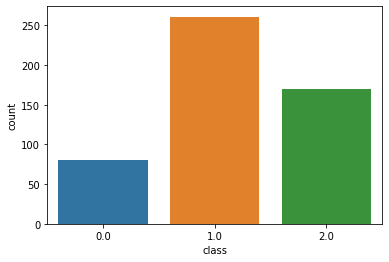

In [ ]:
import seaborn as sns
import warnings
 
warnings.simplefilter('ignore')
sns.countplot(x = "class" , data = new_data_df)

In [ ]:
SEED = 12

220307020903_e6cfdf3e17eb3ba7e4934ea644aba4f2.jpg
220307010339_058c596a07a08781a706d54fd4856ed6.jpg
220307022425_adbbc82f2113157b655744a21be8849b.jpg
220307130847_dd59836101021bc5ad73c9536e11ad01.jpg
220303040236_ae55c3025f83abe4f97cc7b4f15b786f.jpg
220301124047_771a9bc044f44e1ca74b6bc76c72ccd9.jpg
220307004700_250ff3f9bf70f46bbb395353427a86e5.jpg
220302163654_7912adc5d67ca8497685c3a6565d82ca.jpg


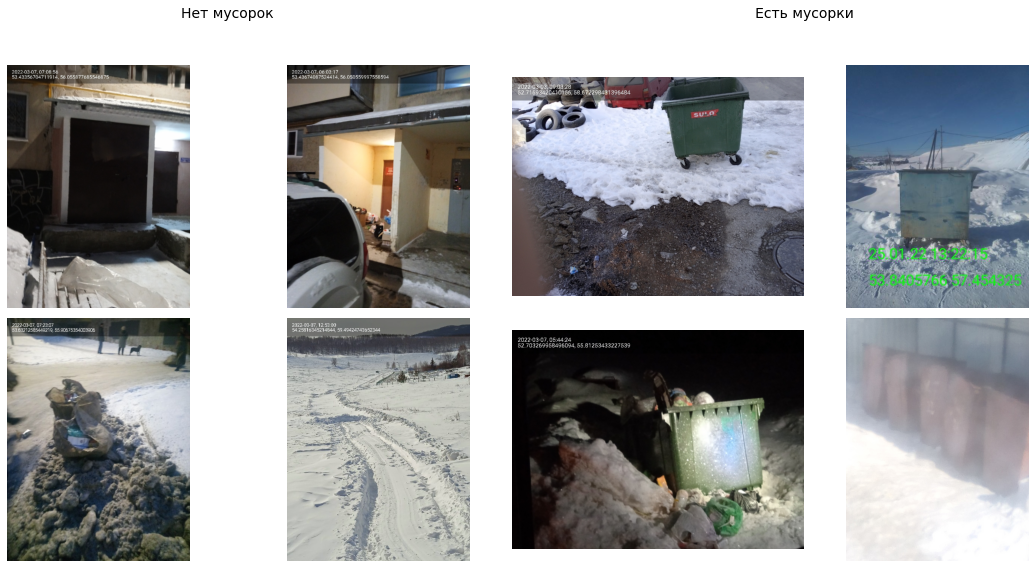

In [ ]:
# посмотрим на картинки. let's look at the images

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Нет мусорок {" "*105} Есть мусорки', fontsize=14)
SEED = SEED + 1
for i, name in zip(range(4), data_df[ data_df['class'] == 0 ].sample(4, random_state=SEED)['ID_img']):
    print(name)
    axs[i // 2, (i % 2)].imshow(plt.imread(f"/content/train/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['class'] == 1 ].sample(4, random_state=SEED)['ID_img']):
    print(name)
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"/content/train/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

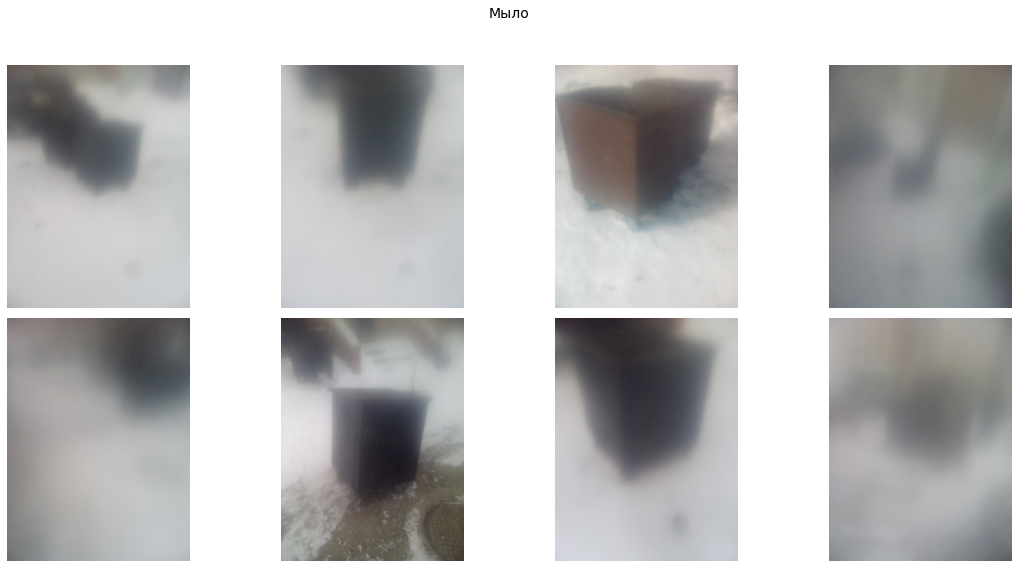

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Мыло', fontsize=14)
n = 120
for i, name in zip(range(4), data_df[ data_df['class'] == 2 ][n:n+4].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"/content/train/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['class'] == 2 ][n+4:n+8].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"/content/train/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')


fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [ ]:
random_states = [41, 19]

In [ ]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(new_data_df, test_size=0.001, random_state=19)

for i in range(8):
    train_df = train_df.append(data_df.iloc[list_interest])

valid_df = valid_df.append(data_df.iloc[list_interest])

In [ ]:
train_df.shape, valid_df.shape

((976, 2), (32, 2))

# Посмотрим насколько разделимы вообще наши данные


In [ ]:
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = nn.Flatten()
feature_extractor = feature_extractor.cuda()
feature_extractor.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
dataset = ImageDataset(new_data_df, valid_transform)
dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=32,
                                           shuffle=False,
                                           pin_memory=True,
                                           num_workers=2,
                                           drop_last=False)

In [ ]:
embeddings = np.zeros((1, 512))
for img, labels in dataloader:
    img = img.cuda()
    emb = feature_extractor(img).cpu().detach().numpy()
    embeddings = np.concatenate((embeddings, emb))

In [ ]:
embeddings = embeddings[1:]
embeddings.shape

(518, 512)

In [ ]:
from sklearn.manifold import TSNE

two_dim = TSNE().fit_transform(embeddings)

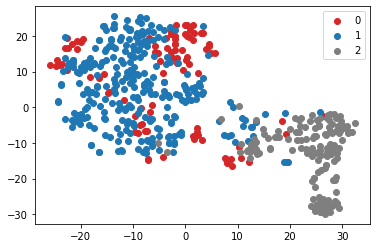

In [ ]:
colors = {0: 'tab:red', 1: 'tab:blue', 2: 'tab:gray'}
for i in range(3):
    plt.scatter(two_dim[new_data_df['class'] == i][:, 0],
                two_dim[new_data_df['class'] == i][:, 1], c=colors[i], label=str(i))

plt.legend(loc='best')
plt.show()

That will be tough...

It defenetly has some problematic regions

# Вспомогательные функции

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
from copy import deepcopy
from sklearn.metrics import roc_auc_score
def train(res_model, criterion, optimizer, sheduler, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []

    milestone = 0
    milestones = list(sheduler.milestones)
    
    train_acc_log = []
    val_acc_log = []
    best_val_acc = -np.inf
    best_val_loss = np.inf
    best_roc_auc = -np.inf
    best_model = None
    
    for epoch in tqdm(range(NUM_EPOCH)):

        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += float(loss)
            train_size += y_pred.size(0)
            
            train_pred += float((y_pred.argmax(1) == labels).sum())

            optimizer.step()

        train_loss_log.append(train_loss / len(train_dataloader))
        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        true_labels = []
        pred_labels = []
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)

                for label in labels:
                  l = [0, 0, 0]
                  l[int(label)] = 1
                  true_labels.append(l)
                
                for predicted in pred.argmax(1):
                  p = [0, 0, 0]
                  p[int(predicted)] = 1
                  pred_labels.append(p)
                
                val_loss += float(loss)
                val_size += pred.size(0)
                
                val_pred += float((pred.argmax(1) == labels).sum())

        true_labels = np.array(true_labels)
        pred_labels = np.array(pred_labels)
        roc_auc = roc_auc_score(true_labels, pred_labels, multi_class='ovo', labels=[0,1,2])

        sheduler.step()
        
        val_loss_log.append(val_loss / len(test_dataloader))
        val_acc_log.append(float(val_pred / val_size))
        
        if roc_auc >= best_roc_auc:
            best_roc_auc = roc_auc
            best_model = deepcopy(model.state_dict())
        clear_output()
        


        print('Train loss:', train_loss_log[-1]*100)
        print('Val loss:', val_loss_log[-1]*100)
        print('Train acc:', train_acc_log[-1]*100)
        print('Val acc:', val_acc_log[-1]*100)
        print('Val score:', roc_auc)

    
    print(f'Best score is {best_roc_auc}')
    print(model.load_state_dict(best_model))
    plot_history(train_loss_log, val_loss_log, 'loss')
    plot_history(train_acc_log, val_acc_log, 'accuracy')
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

# Тренировка

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a1f28c190>]],
      dtype=object)

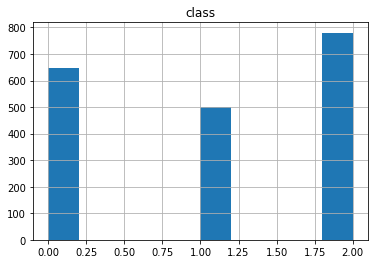

In [ ]:
train_df = train_df.append(train_df[train_df['class'] == 0]).append(train_df[train_df['class'] == 0]).append(train_df[train_df['class'] == 2]).append(train_df[train_df['class'] == 2])
train_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a23dcdb90>]],
      dtype=object)

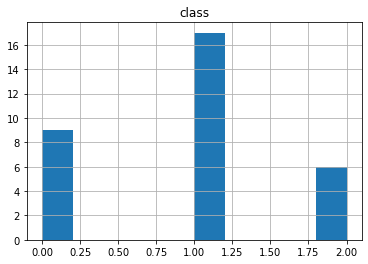

In [ ]:
valid_df.hist()

In [ ]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2,
                                           drop_last=False)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2,
                                           drop_last=False)

In [ ]:
torch.cuda.empty_cache()
model = models.vgg19_bn(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
for param in model.parameters():
    param.requires_grad = False

# for param in model.layer4[-1:].parameters():
#     param.requires_grad = True
  
for param in model.avgpool.parameters():
    param.requires_grad = True

In [ ]:
# Подргружаем модель
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 3)
)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
sheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 30], gamma=0.2)

100%|██████████| 6/6 [12:10<00:00, 121.77s/it]

Train loss: 15.940998876314671
Val loss: 3.326939418911934
Train acc: 94.76141078838174
Val acc: 100.0
Val score: 1.0
Best score is 1.0
<All keys matched successfully>


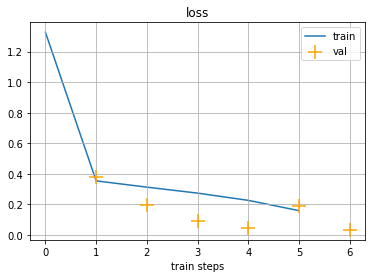

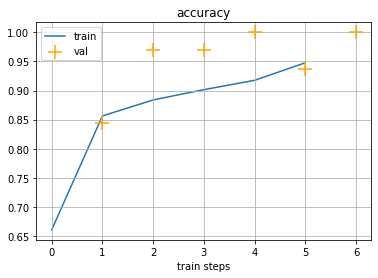

In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                 optimizer, 
                                                                 sheduler, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                #  f1_score,
                                                                 6)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/model_all_e.pth")

## Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def validation_pipeline(blur_model, class_model, valid_df):

    valid_dataset = ImageDataset(valid_df, valid_transform)
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                batch_size=32,
                                                # shuffle=True,
                                                pin_memory=True,
                                                num_workers=2,
                                                drop_last=False)
    
    valid_predicts = []

    blur_model.eval()
    class_model.eval()

    for imgs, _ in tqdm(valid_loader):
        imgs = imgs.cuda()
        blur_pred = (blur_model(imgs).flatten() > 0)
        class_pred = (class_model(imgs).flatten() > 0)

        for i in range(len(imgs)):
            c = None
            if blur_pred[i]:
                c = 2
            else:
                if class_pred[i]:
                    c = 0
                else:
                    c = 1
            valid_predicts.append(c)

    valid_df['pred'] = valid_predicts
    print("Validation accuracy:", accuracy_score(valid_df['class'], valid_df['pred']))

    pred_labels = np.zeros((len(valid_df), 3))
    for i, p in enumerate(valid_df['pred'].values):
        p = int(p)
        pred_labels[i, p] = 1

    val_roc_auc = roc_auc_score(valid_df['class'].values, pred_labels, labels=[0,1,2], multi_class='ovo')
    print(f'Validation roc_auc = {val_roc_auc}')

    mx = confusion_matrix(valid_df["class"], valid_df["pred"], labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(mx, display_labels=['нет мусорки', 'есть мусорка', 'мыло'])
    disp.plot()
    plt.show()

In [ ]:
def single_model_validation_pipeline(model, valid_df):
    valid_dataset = ImageDataset(valid_df, valid_transform)
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                batch_size=32,
                                                # shuffle=True,
                                                pin_memory=True,
                                                num_workers=2,
                                                drop_last=False)
    
    valid_predicts = []
    model.eval()
    for imgs, _ in tqdm(valid_loader):
        imgs = imgs.cuda()
        pred = model(imgs).argmax(1).detach().cpu().numpy()

        for p in pred:
            valid_predicts.append(p)
    
    valid_df['pred'] = valid_predicts
    print(valid_df[valid_df["class"] != valid_df["pred"]])
    print("Validation accuracy:", accuracy_score(valid_df['class'], valid_df['pred']))

    pred_labels = np.zeros((len(valid_df), 3))
    for i, p in enumerate(valid_df['pred'].values):
        p = int(p)
        pred_labels[i, p] = 1

    val_roc_auc = roc_auc_score(valid_df['class'].values, pred_labels, labels=[0,1,2], multi_class='ovo')
    print(f'Validation roc_auc = {val_roc_auc}')

    mx = confusion_matrix(valid_df["class"], valid_df["pred"], labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(mx, display_labels=['нет мусорки', 'есть мусорка', 'мыло'])
    disp.plot()
    plt.show()

100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Empty DataFrame
Columns: [ID_img, class, pred]
Index: []
Validation accuracy: 1.0
Validation roc_auc = 1.0


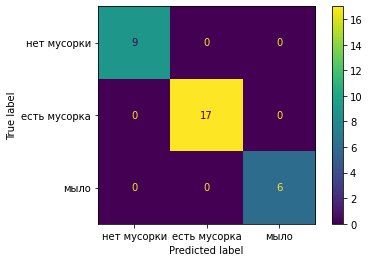

In [ ]:
single_model_validation_pipeline(model, valid_df)

In [ ]:
data_df[data_df['ID_img'] == '220307030919_f345deda73d6ccb2985b00ff538161df.jpg']

,ID_img,class
523,220307030919_f345deda73d6ccb2985b00ff538161df.jpg,1.0


# Предскажем для теста

In [ ]:
test_df = pd.read_csv("/content/sample_solution.csv")
test_df = test_df.drop(["class"], axis = 1)

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']
        
        # читаем картинку
        for extension in ["jpg", "jpeg", "png"]:
            try:
                image = cv2.imread(f"/content/test/{image_name}.{extension}")
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = Image.fromarray(image)
                break
            except Exception as e:
                print(image_name)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [ ]:
len(test_df.ID_img)

225

In [ ]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

#Предсказываем нашей моделью результат

In [ ]:
predicts = []
model.eval()
for imgs in tqdm(test_loader):
    imgs = imgs.cuda()
    pred = model(imgs).argmax(1).detach().cpu().numpy()

    for p in pred:
        predicts.append(p)

  0%|          | 0/4 [00:00<?, ?it/s]

40567458052_99667140804_20508599954_6


100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


In [ ]:
submit_df = pd.DataFrame([[name, pred] for name, pred in zip(test_df.ID_img, predicts)], columns=['ID_img', 'class'])

In [ ]:
submit_df.to_csv("submit.csv", index=False)

In [ ]:
submit_df.shape # (225, 2)

(225, 2)